In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from config import Config
from utils.visualizer import TradingVisualizer
import yfinance as yf
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
data = yf.download('AAPL', start="2019-01-01", end="2023-06-30", auto_adjust=False)

# Y Finance returns multindex columns, with a ticker (name of stock) as the second level (level 1)
'''
Columns: [('Adj Close', 'AAPL'), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Transform to:
Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

'''
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-06-23,184.441116,186.679993,187.559998,185.009995,185.550003,53117000
2023-06-26,183.048019,185.270004,188.050003,185.229996,186.830002,48088700
2023-06-27,185.804565,188.059998,188.389999,185.669998,185.889999,50730800
2023-06-28,186.980301,189.250000,189.899994,187.600006,187.929993,51216800
2023-06-29,187.316208,189.589996,190.070007,188.940002,189.080002,46347300


In [7]:
def create_features(df):
    # =====================
    # BASIC RETURNS
    # =====================
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # =====================
    # ATR (Average True Range)
    # =====================
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    # =====================
    # REALIZED VOLATILITY
    # =====================
    df['realized_vol_5'] = df['log_returns'].rolling(5).apply(lambda x: np.sqrt(np.mean(x**2)))
    df['realized_vol_20'] = df['log_returns'].rolling(20).apply(lambda x: np.sqrt(np.mean(x**2)))
    df['vol_ratio_5_20'] = df['realized_vol_5'] / df['realized_vol_20']

    # =====================
    # SMA RATIOS
    # =====================
    df['sma_5'] = df['Close'].rolling(5).mean()
    df['sma_10'] = df['Close'].rolling(10).mean()
    df['sma_20'] = df['Close'].rolling(20).mean()

    df['price_to_sma_5'] = df['Close'] / df['sma_5']
    df['price_to_sma_10'] = df['Close'] / df['sma_10']
    df['price_to_sma_20'] = df['Close'] / df['sma_20']

    # =====================
    # SMA SLOPES
    # =====================
    def slope(series):
        y = series.values
        x = np.arange(len(y))
        if len(y) < series.size: return np.nan
        slope = np.polyfit(x, y, 1)[0]
        return slope

    df['sma_slope_5'] = df['Close'].rolling(5).apply(slope, raw=False)
    df['sma_slope_10'] = df['Close'].rolling(10).apply(slope, raw=False)
    df['sma_slope_20'] = df['Close'].rolling(20).apply(slope, raw=False)

    # =====================
    # MOMENTUM (normalized)
    # =====================
    df['momentum_5'] = df['Close'].pct_change(5)
    df['momentum_10'] = df['Close'].pct_change(10)

    # =====================
    # RSI
    # =====================
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + RS))

    # =====================
    # STOCH %K and %D
    # =====================
    low14 = df['Low'].rolling(14).min()
    high14 = df['High'].rolling(14).max()
    df['Stoch_K'] = 100 * (df['Close'] - low14) / (high14 - low14)
    df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()

    # =====================
    # VOLUME FEATURES
    # =====================
    df['Volume_zscore'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['OBV_roc'] = df['OBV'].pct_change()

    # =====================
    # CANDLESTICK FEATURES
    # =====================
    df['real_body'] = abs(df['Close'] - df['Open'])
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df['body_to_range'] = df['real_body'] / (df['High'] - df['Low'])

    # =====================
    # MISC
    # =====================
    df['High_Low_range'] = df['High'] - df['Low']
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    return df


In [8]:
create_features(data)
data.dropna(inplace=True)

data.head()

Price,Adj Close,Close,High,Low,Open,Volume,log_returns,H-L,H-PC,L-PC,...,Volume_zscore,OBV,OBV_roc,real_body,upper_shadow,lower_shadow,body_to_range,High_Low_range,day_of_week,month
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,39.564079,41.610001,42.250000,41.139999,41.527500,162958400,0.007175,1.110001,0.937500,0.172501,...,0.072514,5.308532e+08,0.442948,0.082500,0.639999,0.387501,0.074325,1.110001,3,1
2019-02-01,39.583107,41.630001,42.244999,41.482498,41.740002,130672400,0.000481,0.762501,0.634998,0.127502,...,-0.360041,6.615256e+08,0.246155,0.110001,0.504997,0.147503,0.144263,0.762501,4,2
2019-02-04,40.707478,42.812500,42.915001,41.820000,41.852501,125982000,0.028009,1.095001,1.285000,0.189999,...,-0.387737,7.875076e+08,0.190442,0.959999,0.102501,0.032501,0.876711,1.095001,0,2
2019-02-05,41.403954,43.544998,43.770000,43.087502,43.215000,144406400,0.016965,0.682499,0.957500,0.275002,...,0.206450,9.319140e+08,0.183371,0.329998,0.225002,0.127499,0.483514,0.682499,1,2
2019-02-06,41.418213,43.560001,43.892502,43.212502,43.662498,112958400,0.000344,0.680000,0.347504,0.332497,...,-0.639254,1.044872e+09,0.121211,0.102497,0.230003,0.347500,0.150731,0.680000,2,2


In [9]:
feature_flags = {
    # ===== RETURNS =====
    'log_returns': 1,

    # ===== VOLATILITY =====
    'ATR': 1,
    'realized_vol_5': 1,
    'realized_vol_20': 1,
    'vol_ratio_5_20': 1,

    # ===== TREND / SMA RATIOS =====
    'price_to_sma_5': 1,
    'price_to_sma_10': 1,
    'price_to_sma_20': 1,

    # ===== SMA SLOPES =====
    'sma_slope_5': 1,
    'sma_slope_10': 1,
    'sma_slope_20': 1,

    # ===== MOMENTUM =====
    'momentum_5': 1,
    'momentum_10': 1,

    # ===== RSI & STOCHASTICS =====
    'RSI': 1,
    'Stoch_K': 1,
    'Stoch_D': 1,

    # ===== VOLUME =====
    'Volume_zscore': 1,
    'OBV': 1,
    'OBV_roc': 1,

    # ===== CANDLESTICK =====
    'real_body': 1,
    'upper_shadow': 1,
    'lower_shadow': 1,
    'body_to_range': 1,

    # ===== MISC =====
    'High_Low_range': 1,
    'day_of_week': 1,
    'month': 1,

}


In [10]:
# X is the input variable
selected_features = [feat for feat, flag in feature_flags.items() if flag == 1]
X = data[selected_features]

# Y is the target variable
'''
.shift(-5) shifts the data down by 5 row, so the target is the target of 5 days from now
1 if the next day's price is Higher than the current day's price
-1 if the next day's price is Lower than the current day's price
'''
up_threshold = 0.003   # +0.3%
down_threshold = -0.003

future_return = data['Adj Close'].shift(-3) / data['Adj Close'] - 1

y = np.where(future_return > up_threshold, 1, np.where(future_return < down_threshold, -1, 0))   # ignore chop

print(X)
print("_____________")
print(y)


Price       log_returns       ATR  realized_vol_5  realized_vol_20  \
Date                                                                 
2019-01-31     0.007175  1.033751        0.033700         0.032127   
2019-02-01     0.000481  1.047322        0.030384         0.021948   
2019-02-04     0.028009  1.084286        0.032601         0.020822   
2019-02-05     0.016965  1.092143        0.033146         0.021159   
2019-02-06     0.000344  1.089286        0.014994         0.020733   
...                 ...       ...             ...              ...   
2023-06-23    -0.001713  2.959999        0.008231         0.009257   
2023-06-26    -0.007582  2.667856        0.008505         0.009292   
2023-06-27     0.014947  2.698570        0.010815         0.009365   
2023-06-28     0.006308  2.584998        0.010883         0.009169   
2023-06-29     0.001795  2.424285        0.008085         0.009178   

Price       vol_ratio_5_20  price_to_sma_5  price_to_sma_10  price_to_sma_20  \
Date     

In [11]:
dataset_length = data.shape[0]

# Training dataset length
split = int(dataset_length * 0.75)

print(dataset_length)
print(split)

1111
833


In [12]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(833, 26) (278, 26)
(833,) (278,)


In [13]:
# RandomForestClassifier with tunable parameters
# Common parameters you can tune:
# - n_estimators: number of trees (default: 100, try: 50-500)
# - max_depth: max depth of trees (default: None, try: 5-30)
# - min_samples_split: min samples to split a node (default: 2, try: 2-20)
# - min_samples_leaf: min samples in a leaf (default: 1, try: 1-10)
# - max_features: features to consider for split (default: 'sqrt', try: 'sqrt', 'log2', None)
# - random_state: for reproducibility (default: None, set to any integer)
# - class_weight: handle imbalanced classes (default: None, try: 'balanced')

clf = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum depth of trees (None = unlimited)
    min_samples_split=5,   # Minimum samples required to split a node
    min_samples_leaf=2,    # Minimum samples required in a leaf node
    max_features='sqrt',   # Number of features to consider: 'sqrt', 'log2', None, or int
    random_state=42,       # For reproducibility
    class_weight=None      # 'balanced' if classes are imbalanced
)

model = clf.fit(X_train, y_train)

print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

# Run the code to view the classification report metrics
report = classification_report(y_test, model.predict(X_test))
print(report)

Correct Prediction (%):  46.76258992805755
              precision    recall  f1-score   support

          -1       0.39      0.39      0.39       112
           0       0.00      0.00      0.00        16
           1       0.52      0.57      0.55       150

    accuracy                           0.47       278
   macro avg       0.30      0.32      0.31       278
weighted avg       0.44      0.47      0.45       278



c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Rec

In [ ]:
# OPTIONAL: Use GridSearchCV for automated hyperparameter tuning
# This will test multiple parameter combinations and find the best ones
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create base classifier
rf_base = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
# cv=5 means 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',      # Metric to optimize
    n_jobs=-1,              # Use all CPU cores
    verbose=1               # Print progress
)

# Fit the grid search (this may take a while)
print("Starting grid search...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)

# Print best cross-validation score
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f"\nTest set accuracy with best parameters: {test_accuracy:.4f}")

# Classification report for best model
print("\nClassification Report for Best Model:")
print(classification_report(y_test, best_model.predict(X_test)))


Starting grid search...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters found:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Best cross-validation score: 0.5000

Test set accuracy with best parameters: 0.5376

Classification Report for Best Model:
              precision    recall  f1-score   support

          -1       0.56      0.21      0.30       135
           1       0.53      0.85      0.65       144

    accuracy                           0.54       279
   macro avg       0.55      0.53      0.48       279
weighted avg       0.55      0.54      0.48       279



Correct Prediction (%):  52.32974910394266
              precision    recall  f1-score   support

          -1       0.50      0.44      0.47       134
           1       0.54      0.60      0.57       145

    accuracy                           0.52       279
   macro avg       0.52      0.52      0.52       279
weighted avg       0.52      0.52      0.52       279

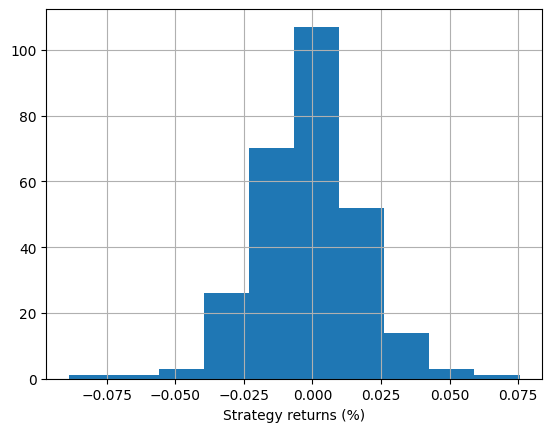

In [ ]:
#Plot strategy returns
data['strategy_returns'] = data.percent_change.shift(-1) * model.predict(X)
import matplotlib.pyplot as plt
data.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

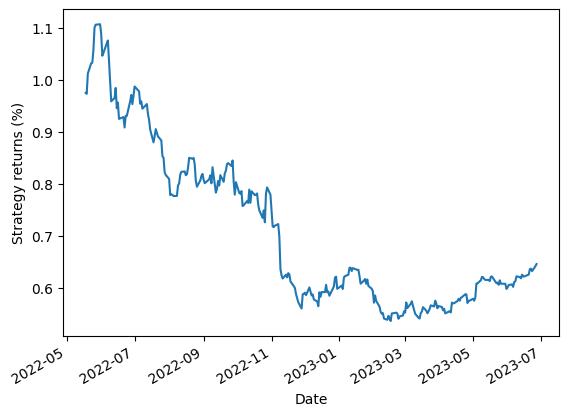

In [ ]:
(data.strategy_returns[split:]+1).cumprod().plot()
plt.ylabel('Strategy returns (%)')
plt.show()